# Neural Art Transfer Using VGG16 and VGG19

### Libraries Required

In [82]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import cv2
import PIL

from tensorflow.keras import Model

We will be using VGG19 Model which is trained on imagenet dataeset having 1000 different classes.

In [83]:
vgg = tf.keras.applications.VGG19(include_top=True, weights="imagenet")

for layers in vgg.layers:
  print(f"{layers.name} ---> {layers.output_shape}")

input_15 ---> [(None, 224, 224, 3)]
block1_conv1 ---> (None, 224, 224, 64)
block1_conv2 ---> (None, 224, 224, 64)
block1_pool ---> (None, 112, 112, 64)
block2_conv1 ---> (None, 112, 112, 128)
block2_conv2 ---> (None, 112, 112, 128)
block2_pool ---> (None, 56, 56, 128)
block3_conv1 ---> (None, 56, 56, 256)
block3_conv2 ---> (None, 56, 56, 256)
block3_conv3 ---> (None, 56, 56, 256)
block3_conv4 ---> (None, 56, 56, 256)
block3_pool ---> (None, 28, 28, 256)
block4_conv1 ---> (None, 28, 28, 512)
block4_conv2 ---> (None, 28, 28, 512)
block4_conv3 ---> (None, 28, 28, 512)
block4_conv4 ---> (None, 28, 28, 512)
block4_pool ---> (None, 14, 14, 512)
block5_conv1 ---> (None, 14, 14, 512)
block5_conv2 ---> (None, 14, 14, 512)
block5_conv3 ---> (None, 14, 14, 512)
block5_conv4 ---> (None, 14, 14, 512)
block5_pool ---> (None, 7, 7, 512)
flatten ---> (None, 25088)
fc1 ---> (None, 4096)
fc2 ---> (None, 4096)
predictions ---> (None, 1000)


NOTE:- Save the VGG19 Weights to present consecutive redownloads.

In [84]:
vggModel.save_weights("./modelWeights/VGG19_Model_Weights.h5")

### Gram MATRIX Function

In [85]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  gram_matrix = tf.expand_dims(result, axis=0)
  input_shape = tf.shape(input_tensor)
  i_j = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return gram_matrix/i_j 

In [86]:
def load_VggModel():
  model=tf.keras.applications.vgg19.VGG19(include_top=True,weights=None)
  model.load_weights("./modelWeights/VGG19_Model_Weights.h5")
  model.trainable=False

  # Model layers for content and style transfer using A Neural Algorithm of Artistic Style
  content_layers=["block4_conv2"]
  style_layers=["block1_conv1","block2_conv1","block3_conv1","block4_conv1","block5_conv1"]
  content_output=model.get_layer(content_layers[0]).output
  style_output=[model.get_layer(style_layer).output for style_layer in style_layers]
  gram_style_output=[gram_matrix(output) for output in style_output]

  StylizationModel=Model([model.input],[content_output,gram_style_output])
  return StylizationModel

### Loading the Content and Style Image

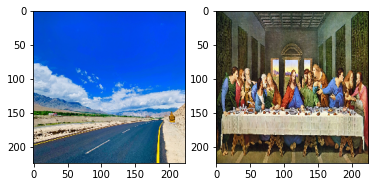

In [87]:
%matplotlib inline
content_image=cv2.resize(cv2.imread("./Images/Content/Ladakh.jpeg"),(224,224))
content_image=tf.image.convert_image_dtype(content_image,tf.float32)
style_image=cv2.resize(cv2.imread("./Images/Style/lastSupper.jpeg"),(224,224))
style_image=tf.image.convert_image_dtype(style_image,tf.float32)
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(np.array(content_image),cv2.COLOR_BGR2RGB))
plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(np.array(style_image),cv2.COLOR_BGR2RGB))
plt.show()

In [88]:
optimizer=tf.optimizers.Adam(learning_rate=0.02,beta_1=0.99,epsilon=1e-1)

In [89]:
def lossFunction(style_outputs, content_outputs, style_target, content_target):
  style_weight = 1e-2
  content_weight = 1e-1
  content_loss = tf.reduce_mean((content_outputs - content_target)**2)
  style_loss = tf.add_n([tf.reduce_mean((output_ - target_)**2) for output_, target_ in zip(style_outputs, style_target)])
  total_loss = content_weight*content_loss + style_weight*style_loss
  return total_loss

In [91]:
vgg_model=load_VggModel()
content_target=vgg_model(np.array([content_image*255]))[0]
style_target=vgg_model(np.array([style_image*255]))[1]

In [92]:
def train_step(image,epoch):
  with tf.GradientTape() as tape:
    output=vgg_model(image*255)
    loss=lossFunction(output[1],output[0],style_target,content_target)
  gradient=tape.gradient(loss,image)
  optimizer.apply_gradients([(gradient,image)])
  image.assign(tf.clip_by_value(image,clip_value_min=0.0,clip_value_max=1.0))

  if epoch%100==0:
    tf.print(f"loss -> {loss}")

In [94]:
EPOCHS=120
image=tf.image.convert_image_dtype(content_image,tf.float32)
image=tf.Variable([image])
for i in range(EPOCHS):
  train_step(image,i)


loss -> 6043300352.0
loss -> 197620768.0


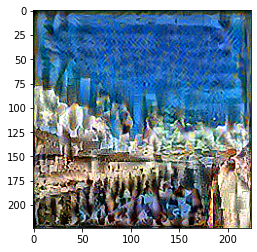

In [95]:
import PIL
tensor=image*255
tensor=np.array(tensor,dtype=np.uint8)
if np.ndim(tensor)>1:
  assert tensor.shape[0]==1
  tensor=tensor[0]
tensor=PIL.Image.fromarray(tensor)
plt.imshow(cv2.cvtColor(np.array(tensor),cv2.COLOR_BGR2RGB))
plt.show()

In [99]:

class NeuralTransfer():
    def __init__(self, content_image_path, style_image_path, EPOCHS=100, style_weight=1e-2, content_weight=1e-1):

        self.content_image = cv2.resize(
            cv2.imread(content_image_path), (224, 224))
        self.style_image = cv2.resize(cv2.imread(style_image_path), (224, 224))
        self.EPOCHS = EPOCHS
        self.style_weight = style_weight
        self.content_weight = content_weight

    def gram_matrix(self, input_tensor):
        result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
        gram_matrix = tf.expand_dims(result, axis=0)
        input_shape = tf.shape(input_tensor)
        i_j = tf.cast(input_shape[1]*input_shape[2], tf.float32)
        return gram_matrix/i_j

    def LoadVgg(self,image):
        model = tf.keras.applications.vgg19.VGG19(
            include_top=True, weights=None)
        model.load_weights("./modelWeights/VGG19_Model_Weights.h5")
        model.trainable = False
        # Model layers for content and style transfer using A Neural Algorithm of Artistic Style
        content_layers = ["block4_conv2"]
        style_layers = ["block1_conv1", "block2_conv1",
                        "block3_conv1", "block4_conv1", "block5_conv1"]
        content_output = model.get_layer(content_layers[0]).output
        style_output = [model.get_layer(
            style_layer).output for style_layer in style_layers]
        gram_style_output = [self.gram_matrix(
            output) for output in style_output]

        StylizationModel = Model(
            [model.input], [content_output, gram_style_output])

        return StylizationModel

    def lossFunction(self, style_outputs, content_outputs, style_target, content_target):
        content_loss = tf.reduce_mean((content_outputs - content_target)**2)
        style_loss = tf.add_n([tf.reduce_mean((output_ - target_)**2)
                              for output_, target_ in zip(style_outputs, style_target)])
        total_loss = self.content_weight*content_loss + self.style_weight*style_loss
        return total_loss

    def optimizer(self):
        opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
        return opt

    def train_step(self, image, epoch, style_target, content_target):
        with tf.GradientTape() as tape:
            output = self.LoadVgg(image*255)
            loss = self.lossFunction(
                output[1], output[0], style_target, content_target)
            gradient = tape.gradient(loss, image)
            self.optimizer.apply_gradients([(gradient, image)])
            image.assign(tf.clip_by_value(
                image, clip_value_min=0.0, clip_value_max=1.0))

        if epoch % 10 == 0:
            tf.print(f"loss -> {loss}")

    def run(self):
        image = tf.image.convert_image_dtype(self.content_image, tf.float32)
        image = tf.Variable([image])
        content_target = self.LoadVgg(np.array([self.content_image*255]))[0]
        style_target = self.LoadVgg(np.array([self.style_image*255]))[1]
        for i in range(self.EPOCHS):
            self.train_step(image, i, style_target, content_target)
        import PIL
        tensor = image*255
        tensor = np.array(tensor, dtype=np.uint8)
        if np.ndim(tensor) > 1:
            assert tensor.shape[0] == 1
            tensor = tensor[0]
        tensor = PIL.Image.fromarray(tensor)
        return tensor

In [100]:
Nt=NeuralTransfer(
    "./Images/Content/Ladakh.jpeg",
    "./Images/Style/MonaLisa.jpeg",
    150,
  )

In [101]:
ans=Nt.run()

TypeError: 'Functional' object is not subscriptable